In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import warnings

import astropy.units as u
import astropy.constants as c
from scipy import interpolate

from read import read_pbh, output_specs

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [2]:
def run_dir(bh_version, log10m, hadron_comment=''):
    return f"/n/home07/yitians/dm21cm/blackhawk/BlackHawk_{bh_version}/results/m{log10m:.3f}_{hadron_comment}"

In [3]:
evol_data = read_pbh(run_dir('v2.3', 14, 'hazma'), 'evolution')
print(evol_data.keys())
out_specs = output_specs(run_dir('v2.3', 14, 'hazma'))
print(' '.join(out_specs['primary']))
print(' '.join(out_specs['secondary']))

dict_keys(['M0', 'rho_comov', 't', 'dt', 'M', 'units'])
strange down charm wpm higgs bottom muon neutrinos top z0 tau electron pion up photon gluon graviton
photon electron


In [4]:
# Hawking temperature
T_H = (c.hbar * c.c**3 / (8 * np.pi * evol_data['M0'] * u.g * c.G)).to('MeV')
T_H

<Quantity 105.72611958 MeV>

In [7]:
# Hawking temperature
T_H = (c.hbar * c.c**3 / (8 * np.pi * 1e15 * u.g * c.G)).to('MeV')
T_H

<Quantity 10.57261196 MeV>

# 1. Energy loss rates

In [30]:
spec = read_pbh(run_dir, 'secondary', particle='electron')
spec['units']

{'E': Unit("eV"), 't': Unit("s"), 'dN_dEdt': Unit("1 / (eV s)")}

In [31]:
spec.keys()

dict_keys(['E', 't', 'dN_dEdt', 'units'])

In [30]:
def get_spec(particle, pri_or_sec, hadron_code='pythia'):
    if particle == 'total':
        spec = read_pbh(run_dir, 'primary', particle='graviton')
        spec_tot_eng = np.trapz(spec['dN_dEdt'] * spec['E'][None, :], x=spec['E'], axis=-1)
        if pri_or_sec == 'primary':
            p_list = [f.split('_')[0] for f in os.listdir(f'../../../blackhawk/BlackHawk_v2.2/results/{run_name}/') if 'primary' in f and 'graviton' not in f]
        else:
            if hadron_code == 'pythia':
                p_list = ['photon', 'electron', 'proton', 'nu_e', 'nu_mu', 'nu_tau']
            elif hadron_code == 'hazma':
                p_list = ['photon', 'electron']
            else:
                raise ValueError(f"Invalid hadron code: {hadron_code}")
        for p in p_list:
            spec = read_pbh(run_dir, pri_or_sec, particle=p)
            spec_tot_eng += np.trapz(spec['dN_dEdt'] * spec['E'][None, :], x=spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    else:
        spec = read_pbh(run_dir, pri_or_sec, particle=particle)
        spec_tot_eng = np.trapz(spec['dN_dEdt'] * spec['E'][None, :], x=spec['E'], axis=-1)
        spec_tot_eng = (spec_tot_eng * u.eV / c.c**2).to('g').value
    return evol_data['t'], spec_tot_eng

def plot_spec(ax, particle, pri_or_sec, hadron_code='pythia', i_start=0, **kwargs):
    t, eng = get_spec(particle, pri_or_sec, hadron_code=hadron_code)
    ax.plot(t[i_start:], eng[i_start:], **kwargs)

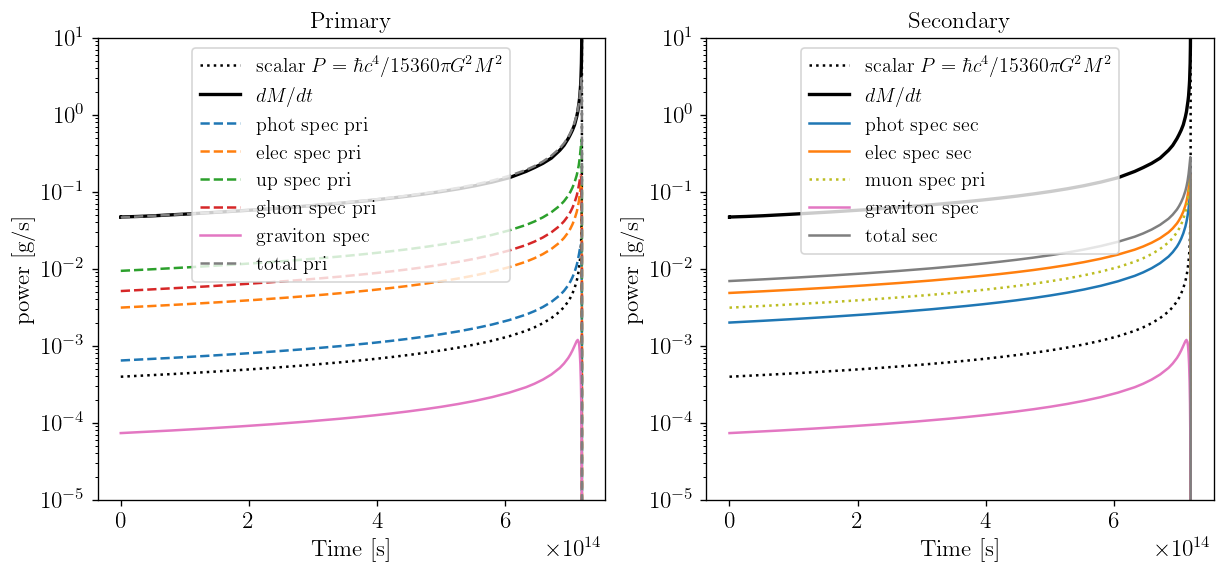

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# theory
power = (c.hbar*c.c**4 / (15360 * np.pi * c.G**2 * evol_data['M']**2 * u.g**2)).to('g/s').value
axs[0].plot(evol_data['t'], power, 'k:', label=r"scalar $P = \hbar c^4 / 15360 \pi G^2 M^2$")
axs[1].plot(evol_data['t'], power, 'k:', label=r"scalar $P = \hbar c^4 / 15360 \pi G^2 M^2$")

# grad(M, t)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]
axs[0].plot(evol_data['t'][i_start:], dMdt[i_start:], color='k', label=r'$dM/dt$', lw=2)
axs[1].plot(evol_data['t'][i_start:], dMdt[i_start:], color='k', label=r'$dM/dt$', lw=2)

# primary spectrum
ax = axs[0]
plot_spec(ax, 'photon',   'primary', i_start=i_start, color='C0', ls='--', label='phot spec pri')
plot_spec(ax, 'electron', 'primary', i_start=i_start, color='C1', ls='--', label='elec spec pri')
plot_spec(ax, 'up',       'primary', i_start=i_start, color='C2', ls='--', label='up spec pri')
plot_spec(ax, 'gluon',    'primary', i_start=i_start, color='C3', ls='--', label='gluon spec pri')
plot_spec(ax, 'graviton', 'primary', i_start=i_start, color='C6', ls='-', label='graviton spec')
plot_spec(ax, 'total',    'primary', i_start=i_start, color='C7', ls='--', label='total pri')

# secondary spectrum
ax = axs[1]
plot_spec(ax, 'photon',   'secondary', i_start=i_start, color='C0', ls='-', label='phot spec sec')
plot_spec(ax, 'electron', 'secondary', i_start=i_start, color='C1', ls='-', label='elec spec sec')
# plot_spec(ax, 'proton',   'secondary', i_start=i_start, color='C2', ls='-', label='proton spec sec')
# plot_spec(ax, 'nu_e',     'secondary', i_start=i_start, color='C3', ls=':', label='nu_e spec sec')
# plot_spec(ax, 'nu_mu',    'secondary', i_start=i_start, color='C4', ls=':', label='nu_mu spec sec')
# plot_spec(ax, 'nu_tau',   'secondary', i_start=i_start, color='C5', ls=':', label='nu_tau spec sec')
plot_spec(ax, 'muon',     'primary', i_start=i_start, color='C8', ls=':', label='muon spec pri')
plot_spec(ax, 'graviton', 'primary', i_start=i_start, color='C6', ls='-', label='graviton spec')

plot_spec(ax, 'total',    'secondary', hadron_code='hazma', i_start=i_start, color='C7', ls='-', label='total sec')

# plotting
axs[0].set(yscale='log', xlabel='Time [s]', ylabel='power [g/s]', title='Primary')
axs[0].set(ylim=(1e-5, 1e1))
axs[0].legend()

axs[1].set(yscale='log', xlabel='Time [s]', ylabel='power [g/s]', title='Secondary')
axs[1].set(ylim=(1e-5, 1e1))
axs[1].legend()

In [ ]:
T_H = (c.hbar * c.c**3 / (8 * np.pi * evol_data['M0'] * u.g * c.G)).to('MeV')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]

t, tot_pri = get_spec('total', 'primary')
t, tot_sec = get_spec('total', 'secondary', hadron_code='hazma')

plt.plot(t, tot_pri / dMdt, label='total pri / dMdt')
plt.plot(t, tot_sec / dMdt, label='total sec / dMdt')
plt.plot(t, np.ones_like(t), 'k:', label='1')

plt.xlabel('time [s]')
plt.title(f'm=1e{log10m:.3f} g   T={T_H.value:.3e} MeV')
plt.yscale('log')
plt.ylim(1e-1, 1.1e0)
plt.legend()

# 2. Spectra : pythia and hazma

Text(0.5, 1.0, 'primary E dN/dE')

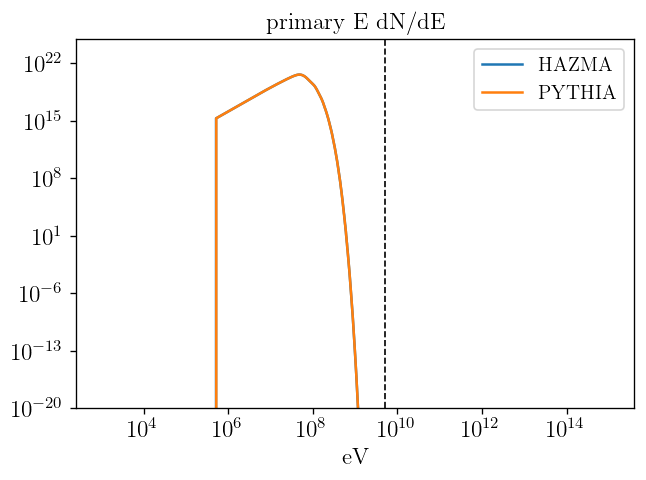

In [6]:
rdir = run_dir('v2.3', 15, 'hazma')
evol_data = read_pbh(rdir, 'evolution')
spec_data = read_pbh(rdir, 'primary', particle='electron')
dNdEdt = interpolate.interp1d(evol_data['M'], spec_data['dN_dEdt'], axis=0)(evol_data['M0']*0.99)
plt.plot(spec_data['E'], spec_data['E']*dNdEdt, label='HAZMA')

rdir = run_dir('v2.3', 15, 'pythia')
evol_data = read_pbh(rdir, 'evolution')
spec_data = read_pbh(rdir, 'primary', particle='electron')
dNdEdt = interpolate.interp1d(evol_data['M'], spec_data['dN_dEdt'], axis=0)(evol_data['M0']*0.99)
plt.plot(spec_data['E'], spec_data['E']*dNdEdt, label='PYTHIA')

plt.axvline(5e9, color='k', ls='--', lw=1)

plt.loglog()
plt.ylim(1e-20, 1e25)
plt.xlabel('eV')
plt.legend()
plt.title('primary E dN/dE')

# M-t

Text(0.5, 1.0, 'M=1e15 g')

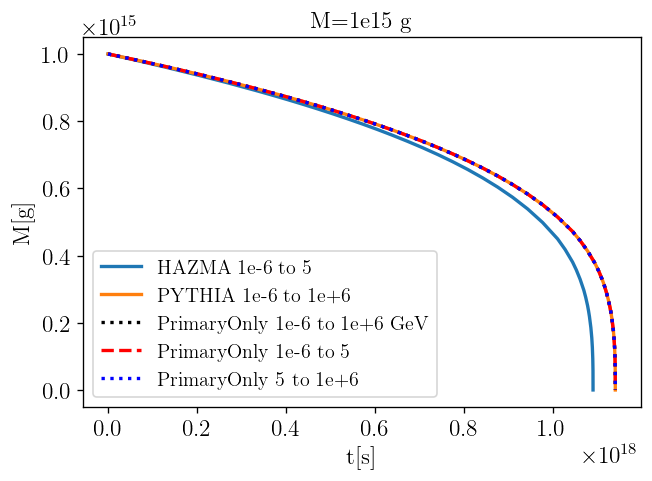

In [13]:
logm = 15

rdir = run_dir('v2.3', logm, 'hazma')
evol_data = read_pbh(rdir, 'evolution')
plt.plot(evol_data['t'], evol_data['M'], lw=2, label='HAZMA 1e-6 to 5')

# rdir = run_dir('v2.3', logm, 'test')
# evol_data = read_pbh(rdir, 'evolution')
# plt.plot(evol_data['t'], evol_data['M'], lw=2, label='HAZMA 1e-6 to 5', ls='--')

rdir = run_dir('v2.3', logm, 'pythia')
evol_data = read_pbh(rdir, 'evolution')
plt.plot(evol_data['t'], evol_data['M'], lw=2, label='PYTHIA 1e-6 to 1e+6')

rdir = run_dir('v2.3', logm, 'primaryonly')
evol_data = read_pbh(rdir, 'evolution')
plt.plot(evol_data['t'], evol_data['M'], 'k:', lw=2, label='PrimaryOnly 1e-6 to 1e+6 GeV')

rdir = run_dir('v2.3', logm, 'primaryonly_1e-6_5')
evol_data = read_pbh(rdir, 'evolution')
plt.plot(evol_data['t'], evol_data['M'], 'r--', lw=2, label='PrimaryOnly 1e-6 to 5')

rdir = run_dir('v2.3', logm, 'primaryonly_5_1e+6')
evol_data = read_pbh(rdir, 'evolution')
plt.plot(evol_data['t'], evol_data['M'], 'b:', lw=2, label='PrimaryOnly 5 to 1e+6')


plt.legend()
plt.xlabel('t[s]')
plt.ylabel('M[g]')
plt.title(f'M=1e{logm} g')

In [ ]:
print(run_dir)

for p, m in zip(['photon', 'electron', 'up', 'gluon', 'muon'], [1, 1, 3, 8, 1]):
    spec_data = read_pbh(run_dir, 'primary', particle=p)
    dNdEdt = interpolate.interp1d(evol_data['M'], spec_data['dN_dEdt'], axis=0)(evol_data['M0']*0.99)
    plt.plot(spec_data['E'], spec_data['E']*dNdEdt/m, label=f'{p}/{m}')

plt.loglog()
plt.ylim(1e10, None)
plt.xlabel('eV')
plt.legend()
plt.title('primary E dN/dE')

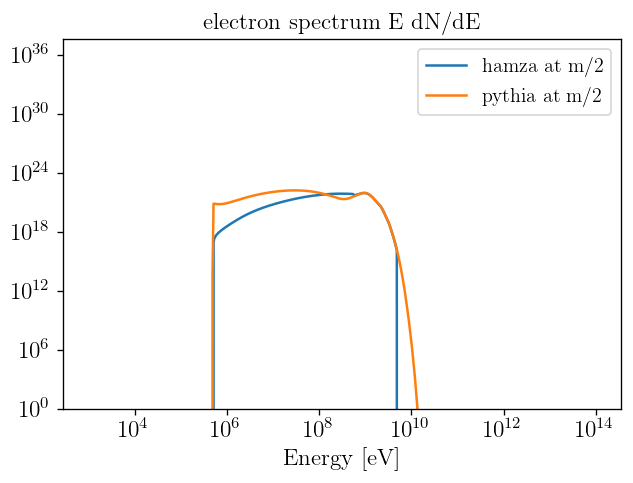

In [28]:
spec_data = read_pbh(run_dir, 'secondary', particle='electron')
dNdEdt_hazma = interpolate.interp1d(evol_data['M'], spec_data['dN_dEdt'], axis=0)(m_to_interp)
plt.plot(spec_data['E'], spec_data['E']*dNdEdt_hazma, label='hamza at m/2')

spec_data_py = read_pbh('/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results_pythia/m14.000_sec', 'secondary', particle='electron')
evol_data_py = read_pbh('/n/home07/yitians/dm21cm/blackhawk/BlackHawk_v2.2/results_pythia/m14.000_sec', 'evolution')
dNdEdt_pythia = interpolate.interp1d(evol_data_py['M'], spec_data_py['dN_dEdt'], axis=0)(m_to_interp)
plt.plot(spec_data_py['E'], spec_data_py['E']*dNdEdt_pythia, label='pythia at m/2')
# spec_data = read_pbh(run_dir, 'primary', particle='photon')
# plt.plot(spec_data['E'], spec_data['E']*spec_data['dN_dEdt'][200], label='primary')
plt.xlabel('Energy [eV]')
plt.title('electron spectrum E dN/dE')
plt.loglog()
plt.ylim(1, None)
plt.legend()

# Conservation in DH evolution

In [28]:
sys.path.append(os.environ['DH_DIR'])
import darkhistory.physics as phys

from scipy import interpolate
from astropy.cosmology import Planck18 as cosmo

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    dMdt = np.abs(np.gradient(evol_data['M'], evol_data['t'])) # [g/s]
i_start = np.where(evol_data['t'] > 1e10)[0][0] # [s]

evol_data['t'][i_start:], dMdt[i_start:]

dMdt_t = interpolate.interp1d(evol_data['t'][i_start:], dMdt[i_start:], kind='linear', fill_value=0, bounds_error=False)

In [41]:
start_rs = 3000
end_rs = 4
coarsen_factor = 1

dlnz = 0.001

rs_s = []
dt_s = []
dM_s = []

rs = start_rs
while rs > end_rs: # darkhistory loop
    dt = dlnz * coarsen_factor / phys.hubble(rs)
    t = cosmo.age(rs-1).to(u.s).value # [s]
    dM = dMdt_t(t) * dt

    rs_s.append(rs)
    dt_s.append(dt)
    dM_s.append(dM)

    rs = np.exp(np.log(rs) - dlnz * coarsen_factor) # next_rs

In [ ]:
plt.plot(rs_s, dM_s)

In [40]:
np.sum(dM_s) / evol_data['M0']

0.4315711884275884

# Archive

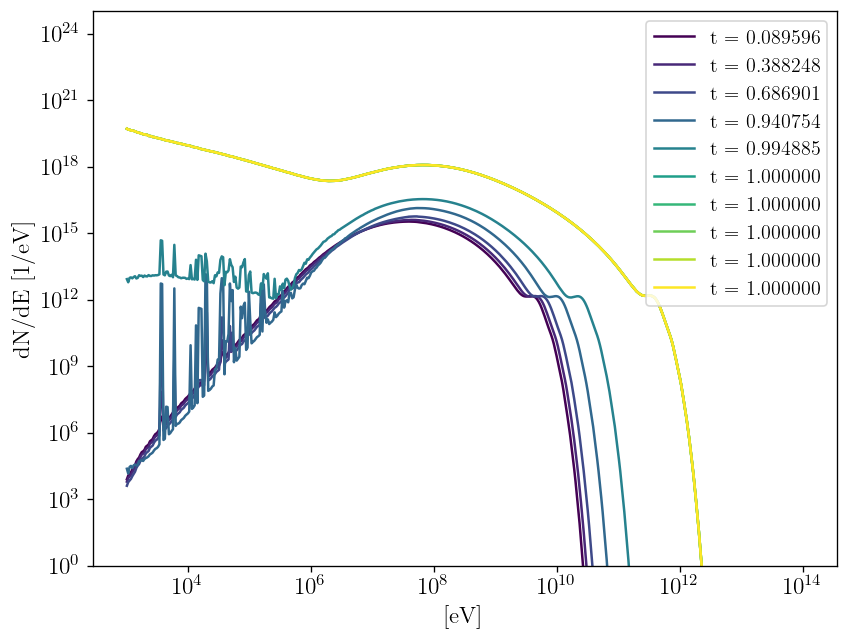

In [71]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'secondary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()

In [74]:
spec['E'].shape

(1000,)

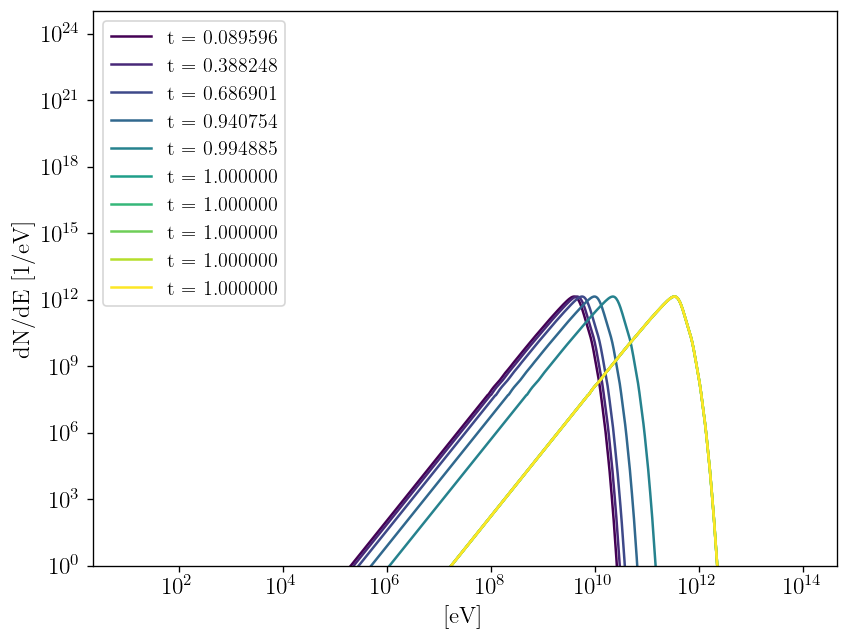

In [75]:
i_show_s = [120, 130, 140, 150, 160, 200, 300, 400, 600, 688]

spec = read_pbh(run_dir, 'primary', particle='photon')
dNdE_interp = interpolate.interp1d(spec['t'], spec['dN_dEdt'], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i, i_show in enumerate(i_show_s):
    t = spec['t'][i_show]
    color = cms['viridis'](i/(len(i_show_s) - 1))
    tf = spec['t'][-1]
    dNdE = dNdE_interp(t)
    ax.plot(spec['E'], dNdE, color=color, label=f't = {t/tf:.6f}')
ax.set(xscale='log', yscale='log')
ax.set(ylim=(1e0, 1e25))
ax.set(xlabel='[eV]', ylabel='dN/dE [1/eV]')
ax.legend()